In [1]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from core.score import plot, plot_confidence_hist, histogram_binning_calibrator
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,transform=tf)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = simple_cnn(y_dim = 10,DROPOUT=True).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-4)


### Training

In [4]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.2946, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0617, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


### Test Accuracy

In [5]:
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        out = torch.softmax(out,-1)
        a,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9857


### Uncertainty

In [6]:
model.train()

total=10

prob = torch.zeros(total,test_id.__len__(),10).to('cuda')

with torch.no_grad():
    n_total = 0     
    for image,label in test_id_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)
mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
id_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
id_score = id_score.cpu().numpy()
print(np.mean(id_score))

prob = torch.zeros(total,test_near_ood.__len__(),10).to('cuda')

with torch.no_grad(): 
    n_total = 0  
    for image,label in test_near_ood_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)

mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
near_ood_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
near_ood_score = near_ood_score.cpu().numpy()
print(np.mean(near_ood_score))

prob = torch.zeros(total,test_far_ood.__len__(),10).to('cuda')

with torch.no_grad():
    n_total = 0        
    for image,label in test_far_ood_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)

mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
far_ood_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
far_ood_score = far_ood_score.cpu().numpy()
print(np.mean(far_ood_score))


0.0048382473
0.043714087
0.053604335


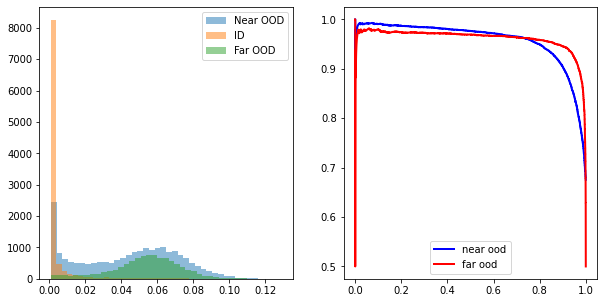

Near AUROC:0.9250799807692307, Far AUROC: 0.9743132050000001


In [7]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='Droout',
                        reverse=True)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

### Calibration

In [16]:
model.train()

total=10

prob = torch.zeros(total,val_id.__len__(),10).to('cuda')
val_y_true = []
with torch.no_grad():
    n_total = 0     
    for image,label in val_id_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)
        val_y_true += label.numpy().tolist()
mean = torch.mean(prob,dim=0) # [N x D]
_, pred_logits = torch.max(mean,dim = -1) # N
val_y_true = torch.LongTensor(val_y_true)
val_y_true = (pred_logits.cpu() == val_y_true).numpy()
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
val_id_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
val_id_score = val_id_score.cpu().numpy()
print(np.mean(val_id_score))


0.0042976947


In [19]:
def plot_confidence_hist(prob_true,prob_pred,NAME):
    plt.figure()
    plt.title(NAME)
    for e,(t,p) in enumerate(zip(prob_true,prob_pred)):
        if e == len(prob_true)-1:
            width = 1-p
        else:
            width = prob_pred[e+1] - p
        plt.bar(p,t,width,align = 'edge',color=[0,0,1,0.2])
    plt.plot([0,1],[0,1])
    plt.show()

ECE(%):  0.29959731564585373


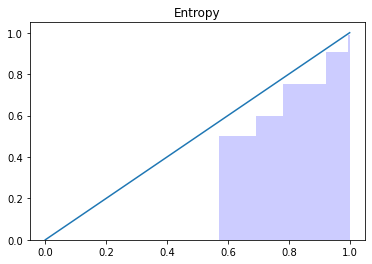

In [21]:
cval_score_en = val_id_score*-1
cid_score_en = id_score* -1
min_en= cval_score_en.min() -0.1 
max_en = cval_score_en.max() +0.1
cal = histogram_binning_calibrator(15,min_en, max_en)
cal.fit(cval_score_en,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score_en, y_true)

plot_confidence_hist(prob_true,prob_pred,'Entropy')